# 1. pib

## Variables

- consumo_privado
- inversiones
- gasto_publico
- exportaciones
- importaciones
- variacion


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import tensorflow as tf

cwd_path = os.getcwd()
data_path = os.path.join(cwd_path, 'data')
input_path = os.path.join(data_path, 'input')
output_path = os.path.join(data_path, 'output')

## Importación de datos

In [ ]:
input_files = {'consumo_privado': ['sector_real', 'pib_gasto', 'gasto_consumo_final_hogar_isflsh.csv'],
         'inversiones': ['sector_real', 'pib_gasto', 'formacion_bruta_capital_fijo.csv'],
          'gasto_publico': ['sector_real', 'pib_gasto', 'gasto_consumo_final_gobierno_central.csv'],
         'exportaciones': ['sector_real', 'pib_gasto', 'exportacion_bienes_servicios.csv'],
         'importaciones': ['sector_real', 'pib_gasto', 'importaciones_bienes_servicios.csv'],
         'variacion' : ['sector_real', 'pib_gasto', 'variacion_existencias.csv'],
             'pib': ['sector_real', 'pib', 'pib.csv']}

input_list = []
for name, path in input_files.items():
  file_path = os.path.join(input_path, *path)
  df_input = (pd
                .read_csv(file_path, sep=',')
                .rename(columns={'Fecha': 'fa', 'Valor': name})
                .assign(fa = lambda df: pd.to_datetime(df['fa'], dayfirst=True))
                .set_index('fa')
                )
  input_list.append(df_input)

df = pd.concat(input_list, axis=1, join='outer')
output_filepath = os.path.join(output_path, 'pib_dataset.xlsx')
df.to_excel(output_filepath)

In [5]:
df

,consumo_privado,inversiones,gasto_publico,exportaciones,importaciones,variacion,pib
fa,,,,,,,
2009-06-30,7645.80,12386.80,66165.10,17180.50,22876.00,-5504.40,74997.80
2009-09-30,8728.90,11359.10,65711.90,16196.50,25296.90,-31.90,76667.60
2009-12-31,9664.60,12432.40,67381.60,18393.60,27584.60,-220.70,80066.90
2010-03-31,7904.40,12062.50,69048.80,20262.00,26222.30,708.70,83764.10
2010-06-30,8587.80,12647.00,70970.00,20276.90,28017.00,-3518.40,80946.30
...,...,...,...,...,...,...,...
2023-06-30,23129.23,31663.98,175761.43,34678.17,64363.65,-21.74,200847.42
2023-09-30,23189.90,34766.21,179216.82,33039.01,66146.42,-367.91,203697.61
2023-12-31,24929.79,34067.36,187342.98,31587.40,66394.61,1163.69,212696.62


## Modelamiento

In [5]:
def data_processing(df, target_var, t_samples, keep_all):
    df_shifted = df[[target_var]].copy()
    for n in range(1, t_samples + 1):
        for col in df.columns:
            df_shifted[f'{col}_t_{n}'] = df[col].shift(n)
    df_shifted = df_shifted.dropna()

    for col in df.columns:
        df_shifted[f'{col}_prom_{t_samples}'] = df_shifted[[f'{col}_t_{i}' for i in range(1, t_samples + 1)]].mean(axis=1)
        df_shifted[f'{col}_desv_{t_samples}'] = df_shifted[[f'{col}_t_{i}' for i in range(1, t_samples + 1)]].std(axis=1)
        df_shifted[f'{col}_min_{t_samples}'] = df_shifted[[f'{col}_t_{i}' for i in range(1, t_samples + 1)]].min(axis=1)
        df_shifted[f'{col}_max_{t_samples}'] = df_shifted[[f'{col}_t_{i}' for i in range(1, t_samples + 1)]].max(axis=1)
        df_shifted[f'{col}_sum_{t_samples}'] = df_shifted[[f'{col}_t_{i}' for i in range(1, t_samples + 1)]].sum(axis=1)

    if not keep_all:
        columns_to_keep = [target_var] + [f'{col}_t_{1}' for col in df.columns] + \
                          [f'{col}_{agg}_{t_samples}' for col in df.columns for agg in ['prom', 'desv', 'min', 'max', 'sum']]
        df_shifted = df_shifted[columns_to_keep]

    return df_shifted

In [6]:
target_var = 'pib'
df_shifted = data_processing(df, target_var, 4, False)

X = df_shifted.drop(columns=[target_var])
y = df_shifted[target_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [7]:
def create_sequences(X, y, timesteps=3):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i + timesteps])
        y_seq.append(y[i + timesteps])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train, y_train.values, timesteps=3)
X_test_seq, y_test_seq = create_sequences(X_test, y_test.values, timesteps=3)

In [ ]:
model_ar = ARIMA(y_train.asfreq('QE'), order=(1, 0, 0), exog=X_train.asfreq('QE')).fit()
model_arima = ARIMA(y_train.asfreq('QE'), order=(1, 0, 1), exog=X_train.asfreq('QE')).fit()

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

model_knn = KNeighborsRegressor()
model_knn.fit(X_train, y_train)

model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)

model_ann = tf.keras.Sequential([
    tf.keras.layers.Input((X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_ann.compile(optimizer='adam', loss='mse', metrics=['mse'])

model_ann.fit(X_train, y_train, epochs=100, verbose=0)

model_rnn = tf.keras.Sequential([
    tf.keras.layers.GRU(64, activation='relu', return_sequences=True),
    tf.keras.layers.GRU(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_rnn.compile(optimizer='adam', loss='mse', metrics=['mse'])
model_rnn.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, verbose=0)

/Users/damoib/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
2024-11-13 21:11:27.133415: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-11-13 21:11:27.133433: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-11-13 21:11:27.133438: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-11-13 21:11:27.133466: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-13 21:11:27.133475: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevi

## Evaluación de Resultados

In [9]:
y_pred_ar = model_ar.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)
mse = mean_squared_error(y_test, y_pred_ar)
print(f"AR: {mse=:,.2f}")

y_pred_arima = model_arima.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)
mse = mean_squared_error(y_test, y_pred_arima)
print(f"ARIMA: {mse=:,.2f}")

y_pred_lr = model_lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lr)
print(f"LinearRegression: {mse=:,.2f}")

y_pred_knn = model_knn.predict(X_test)
mse = mean_squared_error(y_test, y_pred_knn)
print(f"KNeighborsRegressor: {mse=:,.2f}")

y_pred_rf = model_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rf)
print(f"RandomForestRegressor: {mse=:,.2f}")

y_pred_xgb = model_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBRegressor: {mse=:,.2f}")

y_pred_ann = model_ann.predict(X_test)
mse = mean_squared_error(y_test, y_pred_ann)
print(f"ANN: {mse=:,.2f}")

y_pred_rnn = model_rnn.predict(X_test_seq)
mse = mean_squared_error(y_test_seq, y_pred_rnn)
print(f"RNN: {mse=:,.2f}")

AR: mse=922,132,789.75
ARIMA: mse=897,089,161.17
LinearRegression: mse=897,404,738.89
KNeighborsRegressor: mse=1,803,721,238.76
RandomForestRegressor: mse=1,891,719,008.01
XGBRegressor: mse=1,583,632,262.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
ANN: mse=14,212,682.37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
RNN: mse=25,085,534.84


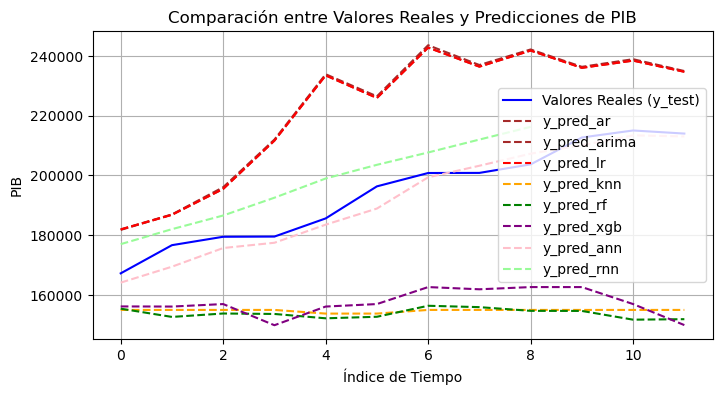

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(y_test.values, label="Valores Reales (y_test)", color="blue")
plt.plot(y_pred_ar.reset_index(drop=True), label="y_pred_ar", color="brown", linestyle="--")
plt.plot(y_pred_arima.reset_index(drop=True), label="y_pred_arima", color="brown", linestyle="--")
plt.plot(y_pred_lr, label="y_pred_lr", color="red", linestyle="--")
plt.plot(y_pred_knn, label="y_pred_knn", color="orange", linestyle="--")
plt.plot(y_pred_rf, label="y_pred_rf", color="green", linestyle="--")
plt.plot(y_pred_xgb, label="y_pred_xgb", color="purple", linestyle="--")
plt.plot(y_pred_ann, label="y_pred_ann", color="pink", linestyle="--")
plt.plot(y_pred_rnn, label="y_pred_rnn", color="palegreen", linestyle="--")
plt.xlabel("Índice de Tiempo")
plt.ylabel("PIB")
plt.title("Comparación entre Valores Reales y Predicciones de PIB")
plt.legend()
plt.grid()
plt.show()